In [42]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import os

client = RemoteAPIClient()
sim = client.getObject('sim')

# Garante que a simulação esteja parada
sim.stopSimulation()

# Limpa a cena atual
sim.closeScene()
sim.loadScene('')  # cena vazia

# ---- Caminhos dos modelos ----
coppelia_base = r'/Users/davifragamarques/Downloads/coppeliaSim 2.app/Contents/Resources/models'
pioneer_model = os.path.join(coppelia_base, 'robots/mobile/Kilobot controller.ttm')
snake_model   = os.path.join(coppelia_base, 'robots/mobile/Snake.ttm')
bill_model    = os.path.join(coppelia_base, 'robots/mobile/Kilobot controller.ttm')  # ajuste se quiser outro modelo para os Bills

# ---- Adiciona Pioneer ----
h_pioneer = sim.loadModel(pioneer_model)
sim.setObjectAlias(h_pioneer, 'Pioneer_p3dx')

# ---- Adiciona Snakes no lugar dos Cuboids ----
snakes = []
for i in range(3):
    h = sim.loadModel(snake_model)
    sim.setObjectPosition(h, -1, [(i+ 1)*0.5, 0, 0])  # ajuste posições se necessário
    sim.setObjectAlias(h, f'Snake[{i}]')
    snakes.append(h)

# ---- Adiciona Bills ----
bills = []
for i in range(2):
    h = sim.loadModel(bill_model)
    sim.setObjectPosition(h, -1, [(i+1)*0.5, 1, 0])
    sim.setObjectAlias(h, f'Bill[{i}]')
    bills.append(h)

print("Cena criada com sucesso!")
print("Handles:")
print("Pioneer:", h_pioneer)
print("Snakes:", snakes)
print("Bills:", bills)


Cena criada com sucesso!
Handles:
Pioneer: 15
Snakes: [18, 49, 80]
Bills: [111, 114]


# sistema de coordenadas


In [43]:
# Função para adicionar "eixos" usando pequenos Snakes como marcadores
def add_coord_frame_with_snakes(handle, scale=0.2):
    # Cria Snakes para representar os eixos
    x_axis = sim.loadModel(snake_model)
    sim.setObjectParent(x_axis, handle, True)
    sim.setObjectPosition(x_axis, handle, [scale, 0, 0])
    sim.setObjectAlias(x_axis, 'X_axis')
    
    y_axis = sim.loadModel(snake_model)
    sim.setObjectParent(y_axis, handle, True)
    sim.setObjectPosition(y_axis, handle, [0, scale, 0])
    sim.setObjectAlias(y_axis, 'Y_axis')
    
    z_axis = sim.loadModel(snake_model)
    sim.setObjectParent(z_axis, handle, True)
    sim.setObjectPosition(z_axis, handle, [0, 0, scale])
    sim.setObjectAlias(z_axis, 'Z_axis')
    
    return x_axis, y_axis, z_axis

# Adiciona sistemas de coordenadas a todos os objetos
add_coord_frame_with_snakes(h_pioneer)
for s in snakes:
    add_coord_frame_with_snakes(s)
for b in bills:
    add_coord_frame_with_snakes(b)

print("Sistemas de coordenadas adicionados usando Snakes como marcadores!")


Sistemas de coordenadas adicionados usando Snakes como marcadores!


# Obter posições e orientações

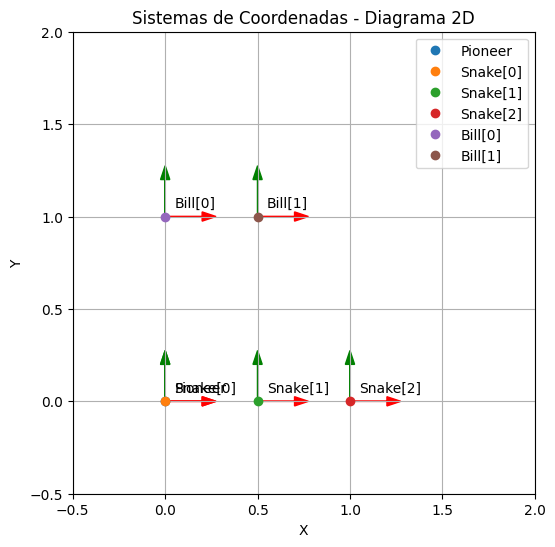

In [44]:
import matplotlib.pyplot as plt

# Posições aproximadas dos objetos (XY, ignorando Z)
objects = {
    'Pioneer': [0, 0],
}

# Snakes
for i, s in enumerate(snakes):
    objects[f'Snake[{i}]'] = [i*0.5, 0]

# Bills
for i, b in enumerate(bills):
    objects[f'Bill[{i}]'] = [i*0.5, 1]

# Criar o gráfico
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlim(-0.5, 2)
ax.set_ylim(-0.5, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Sistemas de Coordenadas - Diagrama 2D')

# Desenhar os objetos e seus eixos
for name, pos in objects.items():
    x, y = pos
    ax.plot(x, y, 'o', label=name)       # ponto do objeto
    ax.arrow(x, y, 0.2, 0, head_width=0.05, color='r')  # eixo X
    ax.arrow(x, y, 0, 0.2, head_width=0.05, color='g')  # eixo Y
    ax.text(x + 0.05, y + 0.05, name)

ax.legend()
plt.show()


# Funções auxiliares para transformações

In [45]:
import numpy as np

def rotz(theta):
    """Matriz de rotação em Z"""
    c, s = np.cos(theta), np.sin(theta)
    return np.array([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ])

def homog_transform(x, y, theta):
    """Matriz homogênea 3x3 em 2D"""
    T = np.eye(3)
    T[0:2,0:2] = rotz(theta)[0:2,0:2]
    T[0:2,2] = [x, y]
    return T

def transform_to_local(T_global_obj, T_global_ref):
    """Transforma a posição global de um objeto para o referencial local de ref"""
    return np.linalg.inv(T_global_ref) @ T_global_obj


In [33]:
# Recupera posições e orientações globais
def get_pose(handle):
    pos = sim.getObjectPosition(handle, -1)  # [x, y, z]
    ori = sim.getObjectOrientation(handle, -1)  # [alpha, beta, gamma] em rad
    return pos, ori

# Pioneer (robô principal)
pos_p, ori_p = get_pose(h_pioneer)
x, y, theta = pos_p[0], pos_p[1], ori_p[2]  # theta = yaw (em 2D)
T_pioneer = homog_transform(x, y, theta)

# Objetos da cena (Snakes e Bills)
objects = {}
for i, s in enumerate(snakes):
    pos, ori = get_pose(s)
    T = homog_transform(pos[0], pos[1], ori[2])
    objects[f'Snake[{i}]'] = T

for i, b in enumerate(bills):
    pos, ori = get_pose(b)
    T = homog_transform(pos[0], pos[1], ori[2])
    objects[f'Bill[{i}]'] = T


# Calculando posições relativas ao Pioneer

In [34]:
relative_objects = {}
for name, T_global in objects.items():
    T_local = transform_to_local(T_global, T_pioneer)
    relative_objects[name] = T_local


# Plotando os referenciais e vetores

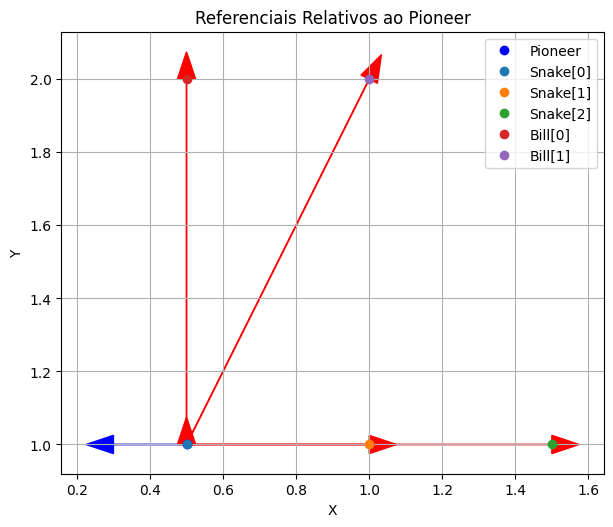

In [46]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,7))
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Referenciais Relativos ao Pioneer')

# Plot Pioneer no referencial global
ax.plot(x, y, 'o', color='blue', label='Pioneer')
ax.arrow(x, y, 0.2*np.cos(theta), 0.2*np.sin(theta), head_width=0.05, color='blue')

# Plot objetos relativos
for name, T_local in relative_objects.items():
    pos_local = T_local[0:2,2]
    ax.plot(x + pos_local[0], y + pos_local[1], 'o', label=name)
    # vetor do Pioneer até o objeto
    ax.arrow(x, y, pos_local[0], pos_local[1], head_width=0.05, color='red')

ax.legend()
plt.show()


# Função para plotar a cena relativo ao Pioneer

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scene_relative_to_pioneer(T_pioneer, objects, title='Cena Relativa ao Pioneer'):
    """
    T_pioneer: matriz homogênea 3x3 do robô
    objects: dict {nome: matriz homogênea 3x3 do objeto}
    """
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    
    # Posição do Pioneer no referencial global
    x, y = T_pioneer[0,2], T_pioneer[1,2]
    theta = np.arctan2(T_pioneer[1,0], T_pioneer[0,0])
    ax.plot(x, y, 'o', color='blue', label='Pioneer')
    ax.arrow(x, y, 0.2*np.cos(theta), 0.2*np.sin(theta), head_width=0.05, color='blue')
    
    # Objetos relativos
    for name, T_global in objects.items():
        # Transformação para o referencial do Pioneer
        T_local = np.linalg.inv(T_pioneer) @ T_global
        pos_local = T_local[0:2,2]
        ax.plot(x + pos_local[0], y + pos_local[1], 'o', label=name)
        ax.arrow(x, y, pos_local[0], pos_local[1], head_width=0.05, color='red')
    
    ax.legend()
    plt.show()


In [50]:
def get_objects_global(objects_handles):
    """
    Retorna um dicionário {nome: T_global} dos objetos dados
    """
    objs = {}
    for name, handle in objects_handles.items():
        pos = sim.getObjectPosition(handle, -1)
        ori = sim.getObjectOrientation(handle, -1)
        T = homog_transform(pos[0], pos[1], ori[2])
        objs[name] = T
    return objs


# Mover o robô para novas posições e plotar

In [51]:
# Dicionário com todos os objetos
objects_handles = {}
for i, s in enumerate(snakes):
    objects_handles[f'Snake[{i}]'] = s
for i, b in enumerate(bills):
    objects_handles[f'Bill[{i}]'] = b

# Novas posições e orientações do robô: [x, y, theta]
new_poses = [
    [0.5, 0.5, 0],          # de frente
    [1.0, 0.5, np.pi/2],    # de lado
    [0.5, 1.0, np.pi]       # de costas
]

for i, (x, y, theta) in enumerate(new_poses):
    # Move o Pioneer
    sim.setObjectPosition(h_pioneer, -1, [x, y, 0])
    sim.setObjectOrientation(h_pioneer, -1, [0, 0, theta])
    
    # Atualiza a matriz homogênea do robô
    T_pioneer_new = homog_transform(x, y, theta)
    
    # Recupera posições globais dos objetos
    objects_global = get_objects_global(objects_handles)
    
    # Plota a cena
    plot_scene_relative_to_pioneer(T_pioneer_new, objects_global, title=f'Pose {i+1} do Pioneer')


ZMQError: Operation cannot be accomplished in current state

# robo com lase agora

In [52]:
# Caminho para o robô com laser
laser_robot_model = os.path.join(coppelia_base, 'robots/mobile/Pioneer_p3dx.ttm')  # Ajuste se for outro modelo com laser

# Remove o robô antigo
sim.removeObject(h_pioneer)

# Adiciona o robô com laser
h_robot = sim.loadModel(laser_robot_model)
sim.setObjectAlias(h_robot, 'Pioneer_Laser')


ZMQError: Operation cannot be accomplished in current state

In [ ]:
def homog_transform(x, y, theta):
    """Matriz homogênea 2D"""
    return np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta),  np.cos(theta), y],
        [0, 0, 1]
    ])

# Matriz Laser -> Robô (LT_R)
# Supondo que o laser está deslocado 0.1m à frente do robô
x_laser, y_laser = 0.1, 0.0
theta_laser = 0  # alinhado com o eixo do robô
LT_R = homog_transform(x_laser, y_laser, theta_laser)


# Ler posição do robô no mundo e calcular Robô -> Mundo

In [ ]:
# Recupera posição e orientação do robô na simulação
pos_robot = sim.getObjectPosition(h_robot, -1)
ori_robot = sim.getObjectOrientation(h_robot, -1)
x_r, y_r, z_r = pos_robot
theta_r = ori_robot[2]

# Matriz Robô -> Mundo (RT_W)
RT_W = homog_transform(x_r, y_r, theta_r)

# Matriz Laser -> Mundo (LT_W)
LT_W = RT_W @ LT_R


# Função para simular leituras do laser

In [ ]:
def simulate_laser_points(LT_W, angles, r=1.0):
    """
    LT_W: matriz homogênea Laser -> Mundo
    angles: ângulos do laser em radianos
    r: alcance do laser
    """
    points = []
    for a in angles:
        # Ponto no referencial do laser
        p_laser = np.array([r*np.cos(a), r*np.sin(a), 1])
        # Transformação para o mundo
        p_world = LT_W @ p_laser
        points.append(p_world[:2])
    return np.array(points)


# Plotar os pontos no referencial global

In [ ]:
def plot_laser_global(points, RT_W, title='Laser no referencial global'):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_aspect('equal')
    ax.grid(True)
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title(title)
    
    # Robô
    x_r, y_r = RT_W[0,2], RT_W[1,2]
    theta_r = np.arctan2(RT_W[1,0], RT_W[0,0])
    ax.plot(x_r, y_r, 'o', color='blue', label='Robô')
    ax.arrow(x_r, y_r, 0.2*np.cos(theta_r), 0.2*np.sin(theta_r), head_width=0.05, color='blue')
    
    # Pontos do laser
    ax.scatter(points[:,0], points[:,1], color='red', label='Laser points')
    ax.legend()
    plt.show()


In [ ]:
# Ângulos simulados do laser (por exemplo -45° a 45°)
angles = np.linspace(-np.pi/4, np.pi/4, 10)

# Posições do robô [x, y, theta]
robot_poses = [
    [0.5, 0.5, 0],
    [1.0, 0.5, np.pi/2],
    [0.5, 1.0, np.pi]
]

for i, (x, y, theta) in enumerate(robot_poses):
    # Move robô na simulação
    sim.setObjectPosition(h_robot, -1, [x, y, 0])
    sim.setObjectOrientation(h_robot, -1, [0, 0, theta])
    
    # Atualiza matrizes
    RT_W = homog_transform(x, y, theta)
    LT_W = RT_W @ LT_R
    
    # Simula pontos do laser
    laser_pts = simulate_laser_points(LT_W, angles, r=1.0)
    
    # Plota
    plot_laser_global(laser_pts, RT_W, title=f'Pose {i+1} do Robô')
